0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


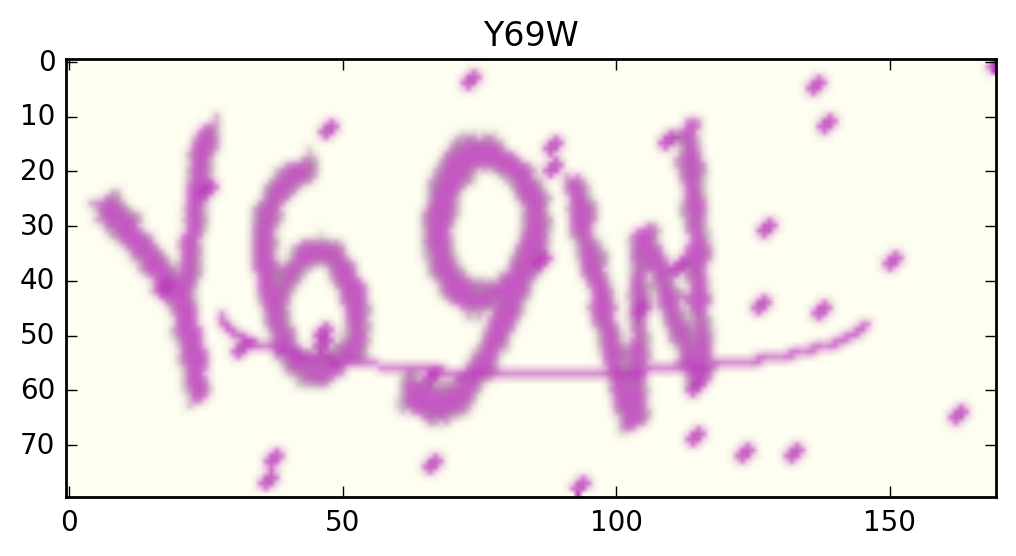

In [16]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import string
characters = string.digits + string.ascii_uppercase
print(characters)
width, height, n_len, n_class = 170, 80, 4, len(characters)
generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)
plt.imshow(img)
plt.title(random_str)

In [17]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

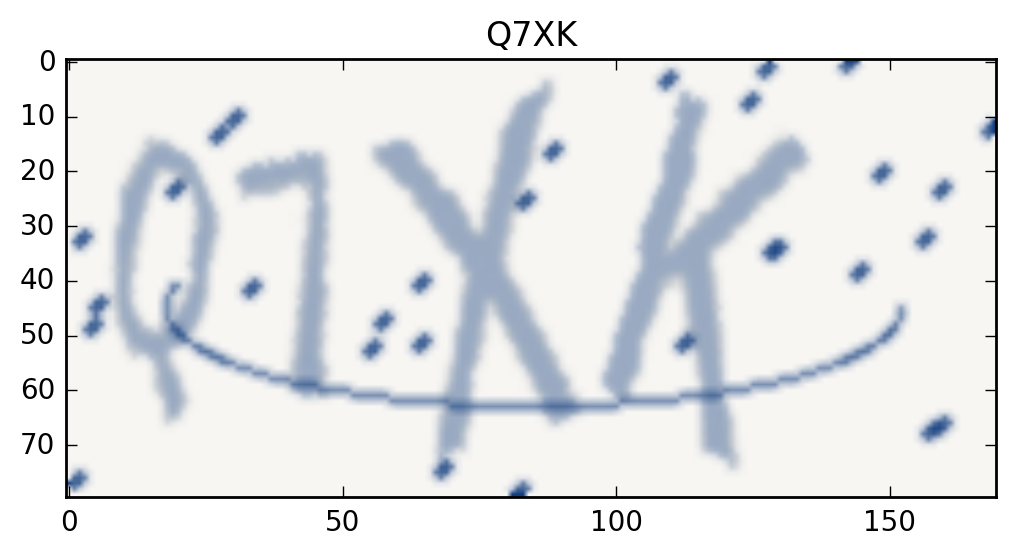

In [18]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])
X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

In [19]:
from keras.models import *
from keras.layers import *
input_tensor = Input((height, width, 3))
x = input_tensor

for i in range(4):
    print x
    x = Convolution2D(32*2**i, (3, 3), 1, activation='relu')(x)
    print x
    x = Convolution2D(32*2**i, (3, 3), 1, activation='relu')(x)
    print x
    x = MaxPooling2D((2, 2))(x)
    print x
# x = Flatten()(x)
# x = Dropout(0.25)(x)
# x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
# model = Model(input=input_tensor, output=x)
# model.compile(loss='categorical_crossentropy',
#               optimizer='adadelta',
#               metrics=['accuracy'])

# import numpy as np
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten
# from keras.layers import Conv2D, MaxPooling2D
# from keras.optimizers import SGD

Tensor("input_10:0", shape=(?, 80, 170, 3), dtype=float32)


TypeError: unsupported operand type(s) for /: 'float' and 'tuple'